we will be creating a relatively simple `ConvNet classifier` that is capable of classifying between <i>Hot Dogs</i> and <i>Not Hot Dogs</i>.

A `Convolutional Neural Network` is a type of neural network that is used in <u>Computer Vision</u> and <u>Natural Language Processing</u> tasks quite often due to the fact that it can learn to extract relevant features from the input data.

it can do two things really well if it is trained properly:
- Generate predictions for new input samples (output layer, which outputs the predictions of the model. This can either be a <u>binary prediction,</u> which is the case for our hot-dog classifier, or a <u>multiclass/multilabel</u> prediction.)
- Extract relevant features from the input data to generate those predictions.


It is not surprising to find (1), which is our case for this classifier, with this class of machine learning models, or with any machine learning model, because it is the essence of the `supervised machine learning` process: training a model with some data in order to make it capable of generating new <u>predictions</u>.

Before we can build the model, it's important that you ensure that your development environment is ready...

In [1]:
%pip install tensorflow numpy opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


`TensorFlow` is an end-to-end open source platform for machine learning.

`keras` provides essential abstractions and building blocks for developing and shipping machine learning solutions with high iteration velocity.

In [19]:
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten
from keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import os
import cv2

### Adding the model configuration


we'll be using 25 x 25 pixel images that are grayscale (hence the <i>1</i> in the `input_shape`), use a `batch size` of <i>10</i> (our data set will be relatively small), <i>25</i> iterations, <i>2</i> classes (not hot dog = 0 / hot dog = 1), and <i>20%</i> of our data will be used for <u>testing purposes</u>. We make the training process <u>verbose</u>, meaning that all results will be printed on screen.

In [11]:
# Configuration
img_width, img_height = 25, 25
input_shape = (img_width, img_height, 1)
batch_size = 10
no_epochs = 25
no_classes = 2
validation_split = 0.2
verbosity = 1

### Loading and preprocessing of the dataset


dataset is available at [Kaggle](https://www.kaggle.com/datasets/thedatasith/hotdog-nothotdog/data)

After downloading, unzip the data, and make sure u follow the following <u>directory structure</u> with respect to this <u>naming conventions</u>:

``` bash
├── assets 
    ├── test
        ├── hot_dog
        ├── not_hot_dog   
    ├── train
        ├── hot_dog
        ├── not_hot_dog
```

Now the following procedure does a couple of things:
- It allows us to specify the `data_type` and the `class_name`. By default, it attempts to load <i>hot_dog</i> images from the <i>train</i> folder.
- It loads the image using imread, as a `grayscale` image - by means of the <i>0</i> specification. We don't want colors of images to interfere with the prediction, as it's all about shape. This is especially important in the case of small datasets, which can be biased. That's why we load the images as `grayscale` ones.
We resize the images to `25 x 25` pixels, in line with the model configuration specified above. Resizing is necessary for two reasons.
    - Firstly, images can be really large sometimes, and this can hamper learning. It's usually best to train your models with images relatively small in size. 
    - Secondly, your model will accept inputs only when they have the shape of the input specified in the Input layer. That's why all images must be using the same number of color channels (that is, either RGB or grayscale, but not both) and be of the same size.
- We append the resized image to the <u>list of instances</u>, and the corresponding class number to the <u>list of classes</u>.
- We return a `tuple` with the <u>instances and classes.</u>

In [12]:
# Load data
def load_data(data_type='train', class_name='hot_dog'):
  instances = []
  classes = []
  for filepath in os.listdir(f'assets/{data_type}/{class_name}'):
    resized_image = cv2.imread(f'assets/{data_type}/{class_name}/{format(filepath)}', 0)
    resized_image = cv2.resize(resized_image, (img_width, img_height))
    instances.append(resized_image)
    classes.append(0 if class_name == 'not_hot_dog' else 1)
  return (instances, classes)

### Creating the model skeleton
we can move on and create a function that creates the model skeleton. Such a skeleton is essentially the representation of the model building blocks - i.e., the architecture. The model itself is not yet alive, and will be instantiated after specifying the skeleton.

The steps performed are simple: a model is created with the `Sequential API`, [three convolutional layers](https://machinecurve.com/index.php/2018/12/07/convolutional-neural-networks-and-their-components-for-computer-vision) are stacked on top of each other (note the increasing number of feature maps with increasing abstractness; we benefit most from learning the abstract representations), a `Flatten` operation which allows the output feature maps to be input by the `Dense` layers, which finally generate a [multiclass probability distribution using Softmax](https://machinecurve.com/index.php/2020/01/08/how-does-the-softmax-activation-function-work).

It finally returns the `model` after creating the skeleton.

In [13]:
# Model creation
def create_model():
  model = Sequential()
  model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(12, kernel_size=(3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))
  return model

### Instantiating the model


Here, we specify things like the `loss function` (we use sparse categorical crossentropy loss because our targets, our y values, are <i>integers</i> rather than one-hot encoded vectors).
We also specify the optimize, which can be `gradient descent-based` or `Adaptive`, like `Adam`.
In addition, we specify <u>additional metrics</u>. 

We then return the model again to be used by the next step.

In [14]:
# Model compilation
def compile_model(model):
  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
  return model

### Running the training process


Here, we accept the <u>model</u> as well as the <u>features</u> and <u>corresponding targets</u> from the training set. Using `configuration options` specified in the model configuration (such as batch size, number of epochs, and verbosity) we start the training process. We do so by calling `model.fit`, which essentially fits the data to the model and attempts to find the `global loss minimum`. Once training has finished, which in our case happens after <i>25 iterations</i> (or epochs), the trained model is returned.

In [38]:
# Model training
def train_model(model, X_train, y_train):
  history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            shuffle=True,
            validation_split=validation_split)
  
  return model, history

### Generating evaluation metrics


This function accepts the <u>trained model</u> as well as the <u>features</u> and <u>targets</u> of your testing dataset. It evaluates the model with those samples and prints test `loss` and `accuracy`. For convenience reasons, this function also returns the trained (and now tested) model.



In [16]:
# Model testing
def test_model(model, X_test, y_test):
  score = model.evaluate(X_test, y_test, verbose=0)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
  return model

### Connecting the building blocks


now time to connect the dots, and specifically do those two things:

- Load and merge training and testing data
- Constructing the model

For both data sets, we use load_data to retrieve our `hot-dog` / `not-hot-dog` data, and eventually merge the two sub datasets each time and create a `np.array` with all the training and testing data, respectively.

In [17]:
# CLICKING EVERYTHING TOGETHER
# Load and merge training data
X_train_nh, y_train_nh = load_data(data_type='train', class_name='not_hot_dog')
X_train_h, y_train_h = load_data(data_type='train', class_name='hot_dog')
X_train = np.array(X_train_nh + X_train_h)
X_train = X_train.reshape((X_train.shape[0], img_width, img_height, 1))
y_train = np.array(y_train_nh + y_train_h)

# Load and merge testing data
X_test_nh, y_test_nh = load_data(data_type='test', class_name='not_hot_dog')
X_test_h, y_test_h = load_data(data_type='test', class_name='hot_dog')
X_test = np.array(X_test_nh + X_test_h)
X_test = X_test.reshape((X_test.shape[0], img_width, img_height, 1))
y_test = np.array(y_test_nh + y_test_h)

### Constructing the model


Finally, constructing the model is essentially connecting the functions we defined above:



In [39]:
# Create and train the model
model = create_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)
model = test_model(model, X_test, y_test)

Epoch 1/25
340/340 [==============================] - 16s 39ms/step - loss: 0.9613 - accuracy: 0.6118 - val_loss: 1.1232 - val_accuracy: 0.0130
Epoch 2/25
340/340 [==============================] - 18s 52ms/step - loss: 0.5781 - accuracy: 0.6852 - val_loss: 1.0148 - val_accuracy: 0.2344
Epoch 3/25
340/340 [==============================] - 19s 57ms/step - loss: 0.4565 - accuracy: 0.7804 - val_loss: 1.3721 - val_accuracy: 0.2297
Epoch 4/25
340/340 [==============================] - 16s 48ms/step - loss: 0.2880 - accuracy: 0.8845 - val_loss: 1.4479 - val_accuracy: 0.4005
Epoch 5/25
340/340 [==============================] - 13s 38ms/step - loss: 0.1450 - accuracy: 0.9443 - val_loss: 2.1906 - val_accuracy: 0.3592
Epoch 6/25
340/340 [==============================] - 13s 37ms/step - loss: 0.0554 - accuracy: 0.9841 - val_loss: 3.8988 - val_accuracy: 0.2686
Epoch 7/25
340/340 [==============================] - 12s 35ms/step - loss: 0.0414 - accuracy: 0.9879 - val_loss: 4.0321 - val_accuracy:

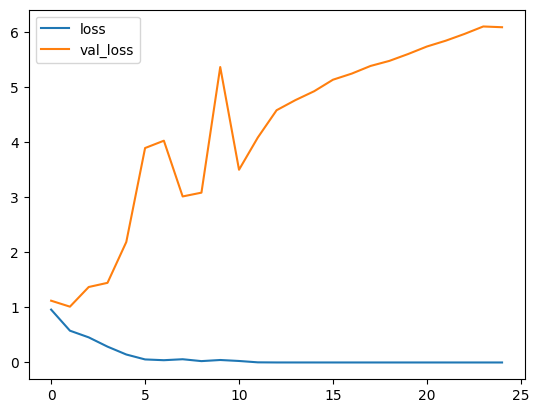

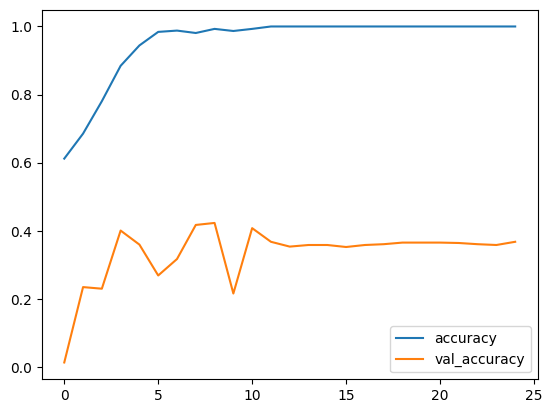

In [40]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();